# Example 10: Composition scaling

In this notebook, we will calculate the free energy of a binary ZrCu system as a function of the composition. The structure that will be considered is ZrCu with a B2 structure. The potential that will be used is-

[M.I. Mendelev , M.J. Kramer , R.T. Ott , D.J. Sordelet , D. Yagodin & P. Popel (2009) Development of suitable interatomic potentials for simulation of liquid and amorphous Cu–Zr alloys, Philosophical Magazine, 89:11, 967-987](http://dx.doi.org/10.1080/14786430902832773)

In [1]:
from calphy.input import read_inputfile
from calphy.routines import routine_composition_scaling
from calphy.alchemy import Alchemy
from calphy.composition_transformation import CompositionTransformation
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
options = read_inputfile("input.yaml")

In [3]:
job = Alchemy(calculation=options[0], simfolder=os.getcwd())

In [4]:
routine_composition_scaling(job)

In [5]:
flambda_arr, netfe, w_arr, mcorrarr = np.loadtxt("composition_sweep.dat", unpack=True)

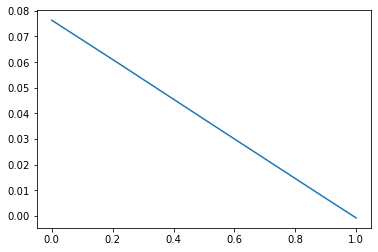

In [6]:
plt.plot(flambda_arr, netfe)

To compare our results, we will use the data from this publication:

[Tang, C, and Peter Harrowell. “Predicting the Solid State Phase Diagram for Glass-Forming Alloys of Copper and Zirconium.” Journal of Physics: Condensed Matter 24, no. 24 (June 20, 2012): 245102.](https://doi.org/10.1088/0953-8984/24/24/245102)

In [7]:
cx = [0.4810, 0.4913, 0.5]
fx = [-5.27, -5.31, -5.34]
ticx = [0.48, 0.49, 0.50]
tifx = [-5.271285338101092, -5.31071206557294, -5.350305821632997]

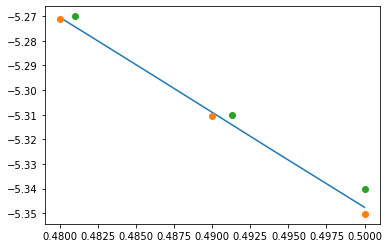

In [11]:
plt.plot(0.50-flambda_arr*(0.50-0.48), tifx[0]-netfe)
plt.plot(ticx, tifx, "o")
plt.plot(cx, fx, "o")